In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import joblib
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns



In [20]:
df = pd.read_csv('./Data/hcm_aqi_dataset_cleaned.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,PM10,PM2.5,CO,NO2,O3,SO2,AQI,UV,Temperature,Humidity,Rain,Wind_Speed,Wind_Dir,month,day,hour,dayofweek,is_weekend
0,2023-01-01 00:00:00,95.0,65.0,993.0,84.4,25.0,37.5,133,0.0,23.5,65,0.0,11.3,9,1,1,0,6,1
1,2023-01-01 01:00:00,86.1,59.0,846.0,70.2,28.0,30.8,133,0.0,23.0,67,0.0,10.3,12,1,1,1,6,1
2,2023-01-01 02:00:00,83.4,57.0,821.0,65.8,26.0,28.9,132,0.0,22.5,70,0.0,7.9,360,1,1,2,6,1
3,2023-01-01 03:00:00,80.1,54.8,834.0,64.0,22.0,28.5,131,0.0,22.0,73,0.0,8.3,360,1,1,3,6,1
4,2023-01-01 04:00:00,69.4,47.5,838.0,60.1,20.0,27.2,129,0.0,21.9,72,0.0,7.9,357,1,1,4,6,1


In [21]:
start_date = '2023-01-01'
test_size = 0.1
lags = [1, 2, 3, 6, 12, 24]
t = 24 # dự đoán cho 24 giờ tiếp theo

# CẮT BỚT dữ liệu

In [22]:
df = df[df['time'] >= start_date].reset_index(drop=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26880 entries, 0 to 26879
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         26880 non-null  datetime64[ns]
 1   PM10         26880 non-null  float64       
 2   PM2.5        26880 non-null  float64       
 3   CO           26880 non-null  float64       
 4   NO2          26880 non-null  float64       
 5   O3           26880 non-null  float64       
 6   SO2          26880 non-null  float64       
 7   AQI          26880 non-null  int64         
 8   UV           26880 non-null  float64       
 9   Temperature  26880 non-null  float64       
 10  Humidity     26880 non-null  int64         
 11  Rain         26880 non-null  float64       
 12  Wind_Speed   26880 non-null  float64       
 13  Wind_Dir     26880 non-null  int64         
 14  month        26880 non-null  int64         
 15  day          26880 non-null  int64         
 16  hour

# Xử lý đặc trưng thô (Thời gian, Hướng gió, Mưa)

In [24]:
# 1. Sắp xếp lại dữ liệu theo thời gian để đảm bảo đúng thứ tự
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# 2. Xử lý Thời gian (Time Features) -> Sin/Cos
# Chuyển đổi thành các giá trị chu kỳ (-1 đến 1)
df['hour_sin']  = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos']  = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['dow_sin']   = np.sin(2 * np.pi * df['time'].dt.dayofweek / 7)
df['dow_cos']   = np.cos(2 * np.pi * df['time'].dt.dayofweek / 7)
df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)
df['doy_sin']   = np.sin(2 * np.pi * df['time'].dt.dayofyear / 365)
df['doy_cos']   = np.cos(2 * np.pi * df['time'].dt.dayofyear / 365)

# 3. Xử lý Hướng gió (Wind Direction) -> Sin/Cos (Yêu cầu mới của bạn)
# Tương tự thời gian, chuyển độ sang radian rồi tính sin/cos
wind_rad = np.deg2rad(df['Wind_Dir'])
df['wind_sin'] = np.sin(wind_rad)
df['wind_cos'] = np.cos(wind_rad)
df = df.drop(columns=['hour', 'dayofweek', 'month', 'day', 'Wind_Dir'])

# 4. Xử lý Mưa -> is_rain
# Nếu Rain > 0 là 1 (có mưa), ngược lại là 0
if 'Rain' in df.columns:
    df['is_rain'] = (df['Rain'] > 0).astype(int)

In [25]:
df.head()

,time,PM10,PM2.5,CO,NO2,O3,SO2,AQI,UV,Temperature,...,hour_cos,dow_sin,dow_cos,month_sin,month_cos,doy_sin,doy_cos,wind_sin,wind_cos,is_rain
0,2023-01-01 00:00:00,95.0,65.0,993.0,84.4,25.0,37.5,133,0.0,23.5,...,1.000000,-0.781831,0.62349,0.5,0.866025,0.017213,0.999852,1.564345e-01,0.987688,0
1,2023-01-01 01:00:00,86.1,59.0,846.0,70.2,28.0,30.8,133,0.0,23.0,...,0.965926,-0.781831,0.62349,0.5,0.866025,0.017213,0.999852,2.079117e-01,0.978148,0
2,2023-01-01 02:00:00,83.4,57.0,821.0,65.8,26.0,28.9,132,0.0,22.5,...,0.866025,-0.781831,0.62349,0.5,0.866025,0.017213,0.999852,-2.449294e-16,1.000000,0
3,2023-01-01 03:00:00,80.1,54.8,834.0,64.0,22.0,28.5,131,0.0,22.0,...,0.707107,-0.781831,0.62349,0.5,0.866025,0.017213,0.999852,-2.449294e-16,1.000000,0
4,2023-01-01 04:00:00,69.4,47.5,838.0,60.1,20.0,27.2,129,0.0,21.9,...,0.500000,-0.781831,0.62349,0.5,0.866025,0.017213,0.999852,-5.233596e-02,0.998630,0


# Rolling and diff

In [26]:
# --- ĐÂY LÀ CELL MỚI CẦN THÊM ---
# Chèn vào sau đoạn tạo 'lag_cols_names' và trước đoạn tạo 'target_cols_names'

# 1. Rolling Mean (Trung bình trượt): Bắt xu hướng trung bình
# Lấy trung bình 3 giờ trước đó (shift 1 để tránh lộ data tương lai)
df['AQI_rolling_mean_3'] = df['AQI'].shift(1).rolling(window=3).mean()
df['AQI_rolling_std_6']  = df['AQI'].shift(1).rolling(window=6).std() # Thêm độ lệch chuẩn để bắt độ biến động

# 2. Difference (Đạo hàm bậc 1 & 2): Bắt tốc độ tăng/giảm (QUAN TRỌNG NHẤT)
# Diff 1: Giờ trước tăng bao nhiêu so với giờ kìa (Velocity)
df['AQI_diff_1'] = df['AQI'].shift(1) - df['AQI'].shift(2)
# Diff 2: Tốc độ tăng thay đổi thế nào (Acceleration)
df['AQI_diff_2'] = df['AQI'].shift(2) - df['AQI'].shift(3)

# Kiểm tra nhanh xem cột đã vào chưa
print("Đã thêm: Rolling Mean, Rolling Std, Diff 1, Diff 2")
# --------------------------------

Đã thêm: Rolling Mean, Rolling Std, Diff 1, Diff 2


# Tạo Lag Features (Quá khứ) và Target (Tương lai)

In [27]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2', 'AQI']
lag_cols_names = []
for col in pollutants:
    for lag in lags:
        col_name = f"{col}_lag_{lag}"
        df[col_name] = df[col].shift(lag) # Shift dương là lấy quá khứ
        lag_cols_names.append(col_name)

# 6. Tạo các cột Target (Giá trị tương lai: AQI từ t+1 đến t+24)
target_cols_names = []
for h in range(1, t+1): # Từ 1 đến 24
    col_name = f"AQI_t+{h}"
    df[col_name] = df['AQI'].shift(-h) # Shift âm là lấy tương lai
    target_cols_names.append(col_name)

df_clean = df.dropna().reset_index(drop=True)
print("Kích thước dữ liệu sau khi tạo lag/target và xóa NaN:", df_clean.shape)

Kích thước dữ liệu sau khi tạo lag/target và xóa NaN: (26832, 95)


In [28]:
df_clean.head()

,time,PM10,PM2.5,CO,NO2,O3,SO2,AQI,UV,Temperature,...,AQI_t+15,AQI_t+16,AQI_t+17,AQI_t+18,AQI_t+19,AQI_t+20,AQI_t+21,AQI_t+22,AQI_t+23,AQI_t+24
0,2023-01-02 00:00:00,65.2,45.4,1539.0,61.1,19.0,2.8,86,0.0,24.8,...,85.0,85.0,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0
1,2023-01-02 01:00:00,74.3,51.8,1736.0,59.7,19.0,3.3,84,0.0,23.9,...,85.0,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0
2,2023-01-02 02:00:00,69.8,48.5,1692.0,59.3,18.0,4.7,84,0.0,23.5,...,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0
3,2023-01-02 03:00:00,61.2,42.5,1546.0,59.2,17.0,6.7,83,0.0,23.4,...,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0,99.0
4,2023-01-02 04:00:00,56.8,39.5,1361.0,58.9,15.0,8.6,82,0.0,23.2,...,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0,99.0,99.0


In [29]:
df_clean.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26832 entries, 0 to 26831
Data columns (total 95 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time                26832 non-null  datetime64[ns]
 1   PM10                26832 non-null  float64       
 2   PM2.5               26832 non-null  float64       
 3   CO                  26832 non-null  float64       
 4   NO2                 26832 non-null  float64       
 5   O3                  26832 non-null  float64       
 6   SO2                 26832 non-null  float64       
 7   AQI                 26832 non-null  int64         
 8   UV                  26832 non-null  float64       
 9   Temperature         26832 non-null  float64       
 10  Humidity            26832 non-null  int64         
 11  Rain                26832 non-null  float64       
 12  Wind_Speed          26832 non-null  float64       
 13  is_weekend          26832 non-null  int64     

# Chia Train/Test (Split)

In [30]:
from sklearn.model_selection import train_test_split

cols_to_drop = ['time'] + target_cols_names

X = df_clean.drop(columns=cols_to_drop, errors='ignore') 
y = df_clean[target_cols_names]

# Chia Train/Test: KHÔNG ĐƯỢC SHUFFLE (vì là chuỗi thời gian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (24148, 70)
X_test shape: (2684, 70)


In [31]:
X

,PM10,PM2.5,CO,NO2,O3,SO2,AQI,UV,Temperature,Humidity,...,SO2_lag_3,SO2_lag_6,SO2_lag_12,SO2_lag_24,AQI_lag_1,AQI_lag_2,AQI_lag_3,AQI_lag_6,AQI_lag_12,AQI_lag_24
0,65.2,45.4,1539.0,61.1,19.0,2.8,86,0.0,24.8,80,...,4.4,30.4,15.7,37.5,90.0,96.0,102.0,116.0,124.0,133.0
1,74.3,51.8,1736.0,59.7,19.0,3.3,84,0.0,23.9,85,...,3.2,6.6,20.5,30.8,86.0,90.0,96.0,113.0,124.0,133.0
2,69.8,48.5,1692.0,59.3,18.0,4.7,84,0.0,23.5,85,...,2.8,5.7,20.5,28.9,84.0,86.0,90.0,108.0,123.0,132.0
3,61.2,42.5,1546.0,59.2,17.0,6.7,83,0.0,23.4,86,...,2.8,4.4,19.1,28.5,84.0,84.0,86.0,102.0,122.0,131.0
4,56.8,39.5,1361.0,58.9,15.0,8.6,82,0.0,23.2,88,...,3.3,3.2,19.4,27.2,83.0,84.0,84.0,96.0,121.0,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26827,34.8,31.7,774.0,49.4,54.0,13.2,73,0.0,27.4,64,...,6.1,8.5,13.0,12.0,75.0,71.0,71.0,71.0,76.0,77.0
26828,34.6,31.9,816.0,49.0,52.0,15.4,71,0.0,25.6,72,...,7.3,7.4,12.7,11.6,73.0,75.0,71.0,71.0,75.0,78.0
26829,33.9,31.4,824.0,48.4,48.0,18.3,71,0.0,25.4,76,...,9.4,6.3,12.2,11.0,71.0,73.0,75.0,71.0,74.0,78.0
26830,34.3,32.2,848.0,47.5,44.0,19.7,72,0.0,25.0,77,...,13.2,6.1,11.5,10.3,71.0,71.0,73.0,71.0,73.0,79.0


In [32]:
y

,AQI_t+1,AQI_t+2,AQI_t+3,AQI_t+4,AQI_t+5,AQI_t+6,AQI_t+7,AQI_t+8,AQI_t+9,AQI_t+10,...,AQI_t+15,AQI_t+16,AQI_t+17,AQI_t+18,AQI_t+19,AQI_t+20,AQI_t+21,AQI_t+22,AQI_t+23,AQI_t+24
0,84.0,84.0,83.0,82.0,81.0,81.0,81.0,83.0,83.0,83.0,...,85.0,85.0,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0
1,84.0,83.0,82.0,81.0,81.0,81.0,83.0,83.0,83.0,84.0,...,85.0,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0
2,83.0,82.0,81.0,81.0,81.0,83.0,83.0,83.0,84.0,84.0,...,86.0,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0
3,82.0,81.0,81.0,81.0,83.0,83.0,83.0,84.0,84.0,85.0,...,93.0,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0,99.0
4,81.0,81.0,81.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,...,91.0,92.0,94.0,96.0,98.0,100.0,101.0,100.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26827,71.0,71.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,75.0,...,79.0,79.0,80.0,81.0,81.0,82.0,102.0,127.0,139.0,136.0
26828,71.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,75.0,75.0,...,79.0,80.0,81.0,81.0,82.0,102.0,127.0,139.0,136.0,124.0
26829,72.0,72.0,73.0,73.0,73.0,74.0,74.0,75.0,75.0,76.0,...,80.0,81.0,81.0,82.0,102.0,127.0,139.0,136.0,124.0,105.0
26830,72.0,73.0,73.0,73.0,74.0,74.0,75.0,75.0,76.0,77.0,...,81.0,81.0,82.0,102.0,127.0,139.0,136.0,124.0,105.0,82.0


# Chuẩn hóa

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

#Phân loại cột
cols_passthrough = ['is_weekend', 'is_rain', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'wind_sin', 'wind_cos']
cols_minmax = ['Humidity']
cols_std_only = ['Temperature', 'AQI_diff_1', 'AQI_diff_2', 'AQI_rolling_mean_3', 'AQI_rolling_std_6']
cols_log_std = [c for c in X_train.columns if c not in cols_passthrough + cols_minmax + cols_std_only]


# Log -> Standard 
log_std_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), # Log transform
    ('scaler', StandardScaler())                            # Sau đó Standard scale
])

# Thiết lập ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_pass', 'passthrough', cols_passthrough),      # Giữ nguyên
        ('minmax', MinMaxScaler(), cols_minmax),            # Chuẩn hóa 0-1
        ('std_only', StandardScaler(), cols_std_only),      # Chuẩn hóa Mean/Std
        ('log_std', log_std_pipeline, cols_log_std)         # Log rồi mới Scale
    ],
    verbose_feature_names_out=False
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



# Kiểm tra sau khi chuẩn hóa

In [34]:
all_cols = cols_passthrough + cols_minmax + cols_std_only + cols_log_std
X_train_final = pd.DataFrame(X_train_processed, columns=all_cols, index=X_train.index)
X_test_final = pd.DataFrame(X_test_processed, columns=all_cols, index=X_test.index)
X_train_final.head()

,is_weekend,is_rain,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,doy_sin,doy_cos,...,SO2_lag_3,SO2_lag_6,SO2_lag_12,SO2_lag_24,AQI_lag_1,AQI_lag_2,AQI_lag_3,AQI_lag_6,AQI_lag_12,AQI_lag_24
0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.5,0.866025,0.034422,0.999407,...,-1.838462,0.754188,-0.175788,1.054070,0.552070,0.778627,0.991559,1.443502,1.677231,1.921457
1,0.0,1.0,0.258819,0.965926,0.0,1.0,0.5,0.866025,0.034422,0.999407,...,-2.208588,-1.334965,0.196273,0.772519,0.392540,0.552025,0.778565,1.351330,1.677231,1.921457
2,0.0,1.0,0.500000,0.866025,0.0,1.0,0.5,0.866025,0.034422,0.999407,...,-2.355987,-1.520575,0.196273,0.681794,0.310003,0.392497,0.551967,1.192180,1.648738,1.894906
3,0.0,0.0,0.707107,0.707107,0.0,1.0,0.5,0.866025,0.034422,0.999407,...,-2.355987,-1.838233,0.097114,0.661961,0.310003,0.309961,0.392443,0.991272,1.620015,1.868155
4,0.0,0.0,0.866025,0.500000,0.0,1.0,0.5,0.866025,0.034422,0.999407,...,-2.173934,-2.208325,0.118932,0.595593,0.268003,0.309961,0.309908,0.778302,1.591058,1.814040


# XG boost

In [35]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import time

# Khởi tạo mô hình
# n_estimators=100: Số lượng cây (tăng lên 500-1000 nếu máy khỏe)
# learning_rate=0.05: Tốc độ học
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, n_jobs=-1, random_state=42)

# Bọc trong MultiOutputRegressor để dự báo 24 cột cùng lúc
model = MultiOutputRegressor(xgb)

print("Đang huấn luyện mô hình... (Có thể mất vài phút tùy dữ liệu)")
start_time = time.time()

# Train
model.fit(X_train_processed, y_train)

print(f"Huấn luyện xong trong {time.time() - start_time:.2f} giây!")

Đang huấn luyện mô hình... (Có thể mất vài phút tùy dữ liệu)
Huấn luyện xong trong 24.18 giây!


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Dự báo trên tập Test
y_pred = model.predict(X_test_processed)

# 2. Tính toán sai số
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"RMSE (Sai số trung bình phương): {rmse:.2f}")
print(f"MAE  (Sai số tuyệt đối):        {mae:.2f}")
print(f"R²   (Hệ số xác định):         {r2:.2f}")


--- KẾT QUẢ ĐÁNH GIÁ ---
RMSE (Sai số trung bình phương): 11.54
MAE  (Sai số tuyệt đối):        7.59
R²   (Hệ số xác định):         0.68


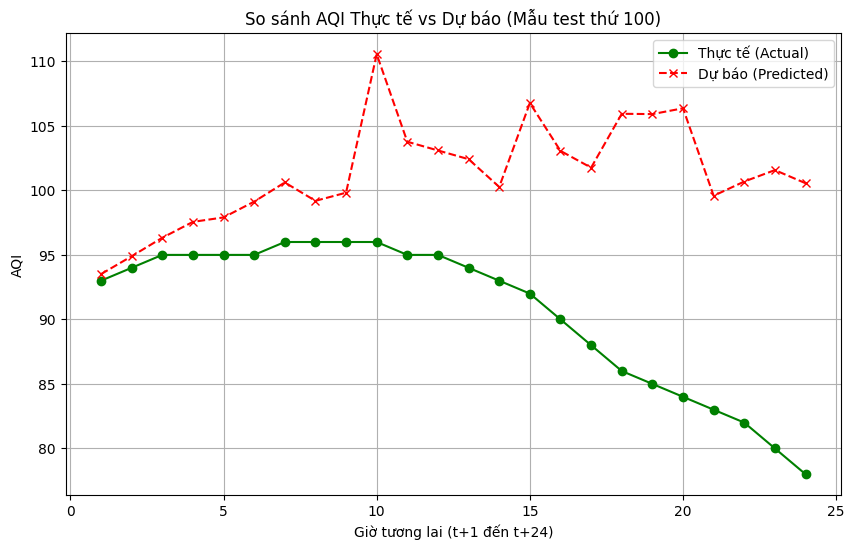

In [37]:
import matplotlib.pyplot as plt
# Chọn ngẫu nhiên 1 thời điểm trong tập test để kiểm tra
# Ví dụ: Lấy mẫu thứ 100 trong tập test
sample_idx = 100

# Lấy dữ liệu thực tế và dự báo của mẫu đó
y_true_sample = y_test.iloc[sample_idx].values
y_pred_sample = y_pred[sample_idx]

# Tạo khung thời gian giả định (1h đến 24h tới)
hours = range(1, t+1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(hours, y_true_sample, marker='o', label='Thực tế (Actual)', color='green')
plt.plot(hours, y_pred_sample, marker='x', label='Dự báo (Predicted)', color='red', linestyle='--')

plt.title(f'So sánh AQI Thực tế vs Dự báo (Mẫu test thứ {sample_idx})')
plt.xlabel(f'Giờ tương lai (t+1 đến t+{t})')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

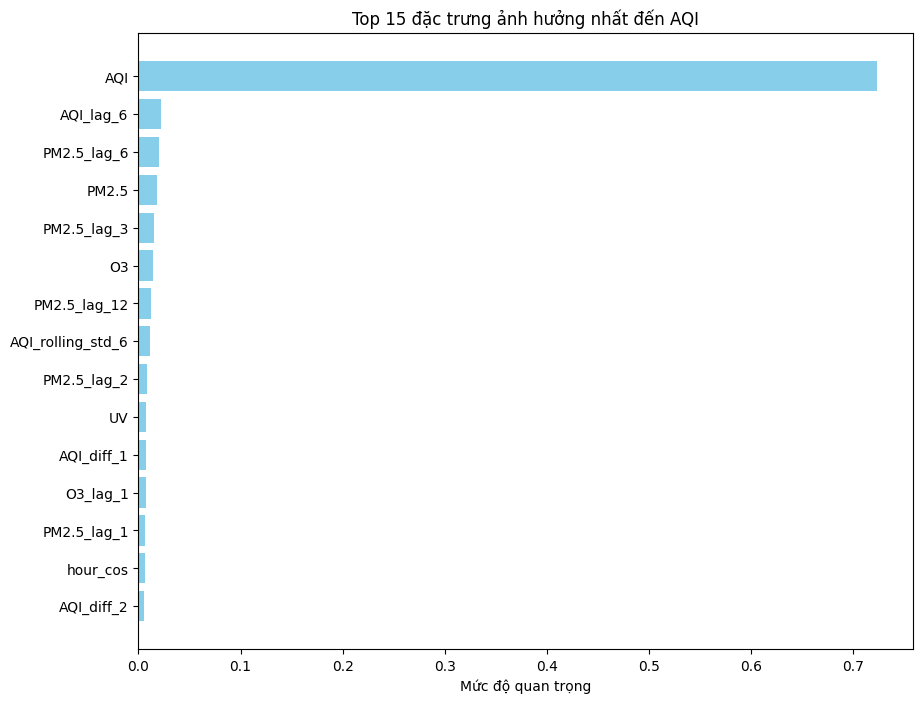

In [18]:
# Lấy danh sách tên cột sau khi xử lý (từ bước trước)
# Nếu bạn chưa lưu tên cột ở bước trước, có thể cần lấy lại từ X_train_final.columns
feature_names = X_train_final.columns 

# Lấy feature importance trung bình của tất cả các cây dự báo
importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)

# Tạo dataframe để sort cho dễ nhìn
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15) # Top 15

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='skyblue')
plt.xlabel('Mức độ quan trọng')
plt.title('Top 15 đặc trưng ảnh hưởng nhất đến AQI')
plt.gca().invert_yaxis() # Đảo ngược để cột quan trọng nhất lên đầu
plt.show()

In [38]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

# 1. Khởi tạo mô hình cơ sở
# Lưu ý: Không set cứng n_estimators hay learning_rate ở đây nữa, để GridSearch tự chọn
xgb = XGBRegressor(random_state=42, n_jobs=-1) 

# Bọc trong MultiOutputRegressor
model = MultiOutputRegressor(xgb)

# 2. Thiết lập lưới tham số (Parameter Grid)
# QUAN TRỌNG: Phải dùng tiền tố 'estimator__' vì model đang nằm trong wrapper MultiOutputRegressor
param_grid = {
    'estimator__n_estimators': [100, 200, 300],  # Số lượng cây
    'estimator__learning_rate': [0.05, 0.1],     # Tốc độ học
    'estimator__max_depth': [3, 5]               # Độ sâu tối đa của cây (tránh overfitting)
}

# 3. Cấu hình GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                           # Chia 3 fold (nhanh hơn 5 fold)
    scoring='neg_mean_squared_error', # Tiêu chí tối ưu là giảm thiểu lỗi MSE
    n_jobs=-1,                      # Chạy song song tất cả nhân CPU
    verbose=1                       # Hiển thị log đơn giản
)

print("Đang chạy Grid Search để tìm tham số tốt nhất...")
start_time = time.time()

# 4. Train (GridSearch sẽ tự chia train/val nội bộ)
grid_search.fit(X_train_processed, y_train)

print(f"Hoàn thành Grid Search trong {time.time() - start_time:.2f} giây!")

# 5. Lấy ra bộ tham số tốt nhất
print(f"Tham số tốt nhất tìm được: {grid_search.best_params_}")

# Lấy mô hình tốt nhất đã được train xong
best_model = grid_search.best_estimator_

# --- PHẦN ĐÁNH GIÁ (Giữ nguyên logic của bạn) ---

# 1. Dự báo trên tập Test bằng mô hình tốt nhất
y_pred = best_model.predict(X_test_processed)

# 2. Tính toán sai số
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- KẾT QUẢ ĐÁNH GIÁ (BEST MODEL) ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.2f}")

# 3. Vẽ biểu đồ (Giữ nguyên code của bạn)
sample_idx = 100
y_true_sample = y_test.iloc[sample_idx].values
y_pred_sample = y_pred[sample_idx]
t = 24 # Giả sử bạn đang dự báo 24h
hours = range(1, t+1)

plt.figure(figsize=(10, 6))
plt.plot(hours, y_true_sample, marker='o', label='Thực tế', color='green')
plt.plot(hours, y_pred_sample, marker='x', label='Dự báo (Best Model)', color='red', linestyle='--')
plt.title(f'So sánh AQI Thực tế vs Dự báo (Mẫu test thứ {sample_idx})')
plt.xlabel(f'Giờ tương lai')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

Đang chạy Grid Search để tìm tham số tốt nhất...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 